# Proyectando el comportamiento de la soja

_Competencia Metadata 2019_  
_https://metadata.fundacionsadosky.org.ar/competition/11/_

## Objetivos
1. Lograr el mejor fit para la serie de retornos simples diarios $\frac{p_1 - p_0}{p_0}$. Serie desde la Fecha de Cierre del Concurso (FCC 29/9/2019) + 10 días hábiles.
2. Lograr la mejor proyección para el último valor de la serie contínua de la soja al fin del concurso. Cierra a la FCC + 10 días hábiles.
3. Lograr el mejor fit para la serie de retornos simples diarios de 4 semanas. Desde FCC - 10 días hábiles, hasta FCC + 10 días hábiles.

## Dataset oficial

[Dataset](https://drive.google.com/file/d/1r0DWiUIQ_N13HeervqrUhbV3TjUlEe4Q/view?usp=sharing) la información que contiene este archivo es hasta el día 29/8/2019. Por ende para calcular el score circunstancial se entiende que usted está proyectando hasta el día 12/9/2019. Esta información se irá actualizando todas las semanas hasta la última actualización que será el día 27/9/2019.

## Descripción

- `Fecha` Fecha de referencia para el precio.
- `Open` Precio de apertura del día.
- `High` Precio máximo del día.
- `Low` Precio mínimo del día.
- `Last` Precio último operado del día.
- `Cierre` Precio de ajuste del día. **Ésta es la serie a proyectarse.**
- `Aj.Dif.` Diferencia nominal respecto del día anterior.
- `Mon` Moneda de denominación del contrato.
- `Oi.Vol` Interés abierto del contrato.
- `Oi.Dif.` Diferencia del interés abierto respecto del día anterior.
- `Vol.Ope.` Volumen Operado medido en contratos.
- `Unidad` Unidad en que se miden los contratos.
- `DolarB.N.` Precio del dólar del Banco de la Nación Argentina.
- `DolarItau` Precio del dólar del Banco Itaú.
- `Diff.Sem` Diferencia Semanal.

## Métrica

La calificación de la solución propuesta se hace con el error absoluto medio ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) por su sigla en inglés) y se calcula como el promedio de las diferencias (en valor absoluto) entre las respuestas enviadas y las correctas:

$$ MAE = \frac{1}{n} \sum_{j=1}^{n} |y_j - \hat{y_j} | $$

## Formato de respuesta

Debe enviarse un archivo en formato `csv` sin encabezado con 4 columnas y 20 filas.

- Primer columna debe contener al número de fila (int).
- Segunda columna debe contener las fechas correspondientes en formato "dd/mm/YYYY."
- Tercer columna debe contener los retornos (float).
- Cuarta columna debe contener el precio (cierre del día) del contrato (float).

Las filas 1 a 10 corresponden a FCC - 10 días hábiles y las filas 11 a 20 corresponden a la proyección futura.

## Exploración

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import pyflux as pf
import seaborn as sns
import statsmodels.api as sm

warnings.simplefilter('ignore')
register_matplotlib_converters()

In [2]:
sns.set(rc={'figure.figsize': (12,8)})

In [3]:
data_dir = 'data'

In [4]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv(os.path.join(data_dir, 'datasetRofex2.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

In [5]:
df.head()

,Id,Open,High,Low,Last,Cierre,Aj.Dif.,Mon.,OI.Vol.,OI.Dif.,Vol.Ope.,Unidad,DolarB.N.,DolarItau.,Dif.Sem
Fecha,,,,,,,,,,,,,,,
2004-01-05,1,0.0,0.0,0.0,0.0,221.0,13.0,D,0.0,0.0,0,TONS,2.920,2.905,-221.0
2004-01-06,2,0.0,0.0,0.0,0.0,221.0,0.0,D,0.0,0.0,0,TONS,2.880,2.870,-221.0
2004-01-07,3,0.0,0.0,0.0,0.0,219.0,-2.0,D,0.0,0.0,0,TONS,2.865,2.882,-219.0
2004-01-08,4,0.0,0.0,0.0,0.0,220.0,1.0,D,0.0,0.0,0,TONS,2.887,2.884,-220.0
2004-01-09,5,0.0,0.0,0.0,0.0,220.0,0.0,D,0.0,0.0,0,TONS,2.892,2.900,-220.0


Empezamos con un plot del precio de cierre en cada día.

In [ ]:
df['Cierre'].plot(title='Precio diario de cierre de Soja FAS');

El gráfico sugiere que se trata de una serie no [estacionaria](https://es.wikipedia.org/wiki/Proceso_estacionario), con un *trend* marcado. Podemos confirmar esto con un gáfico de [autocorrelación](https://otexts.com/fpp2/autocorrelation.html). Más aún, con el plot de [autocorrelacion parcial](https://es.wikipedia.org/wiki/Función_de_autocorrelación_parcial), podemos ver que la maxima autocorrelacion esta en el primer lag.

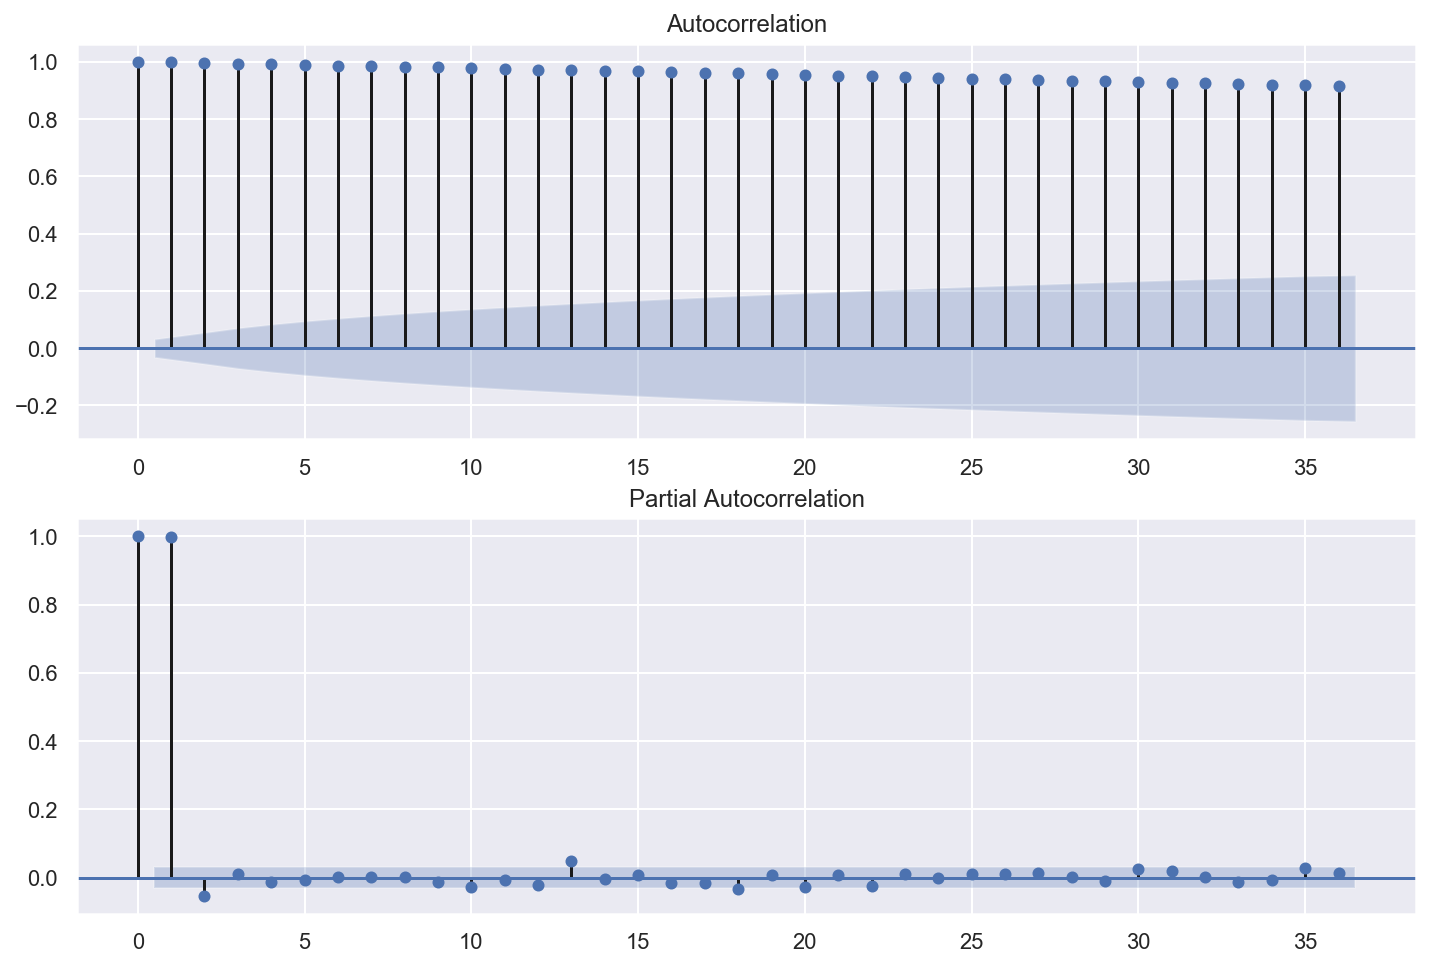

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df['Cierre'], ax=ax1)
sm.graphics.tsa.plot_pacf(df['Cierre'], ax=ax2);

Si la serie fuera estacionaria, uno esperaría que la autocorrelación decreciera rápidamente al aumentar el *lag*, pero esto no es así. Nuestro objetivo, sin embargo, no es predecir el precio de cierre sino el retorno diario, que es (casi) la serie diferenciada. Veamos la autocorrelación de estos retornos.

In [8]:
df['retorno'] = df['Cierre'].pct_change()
df['log_retorno'] = np.log(df['Cierre'] / df['Cierre'].shift(1))

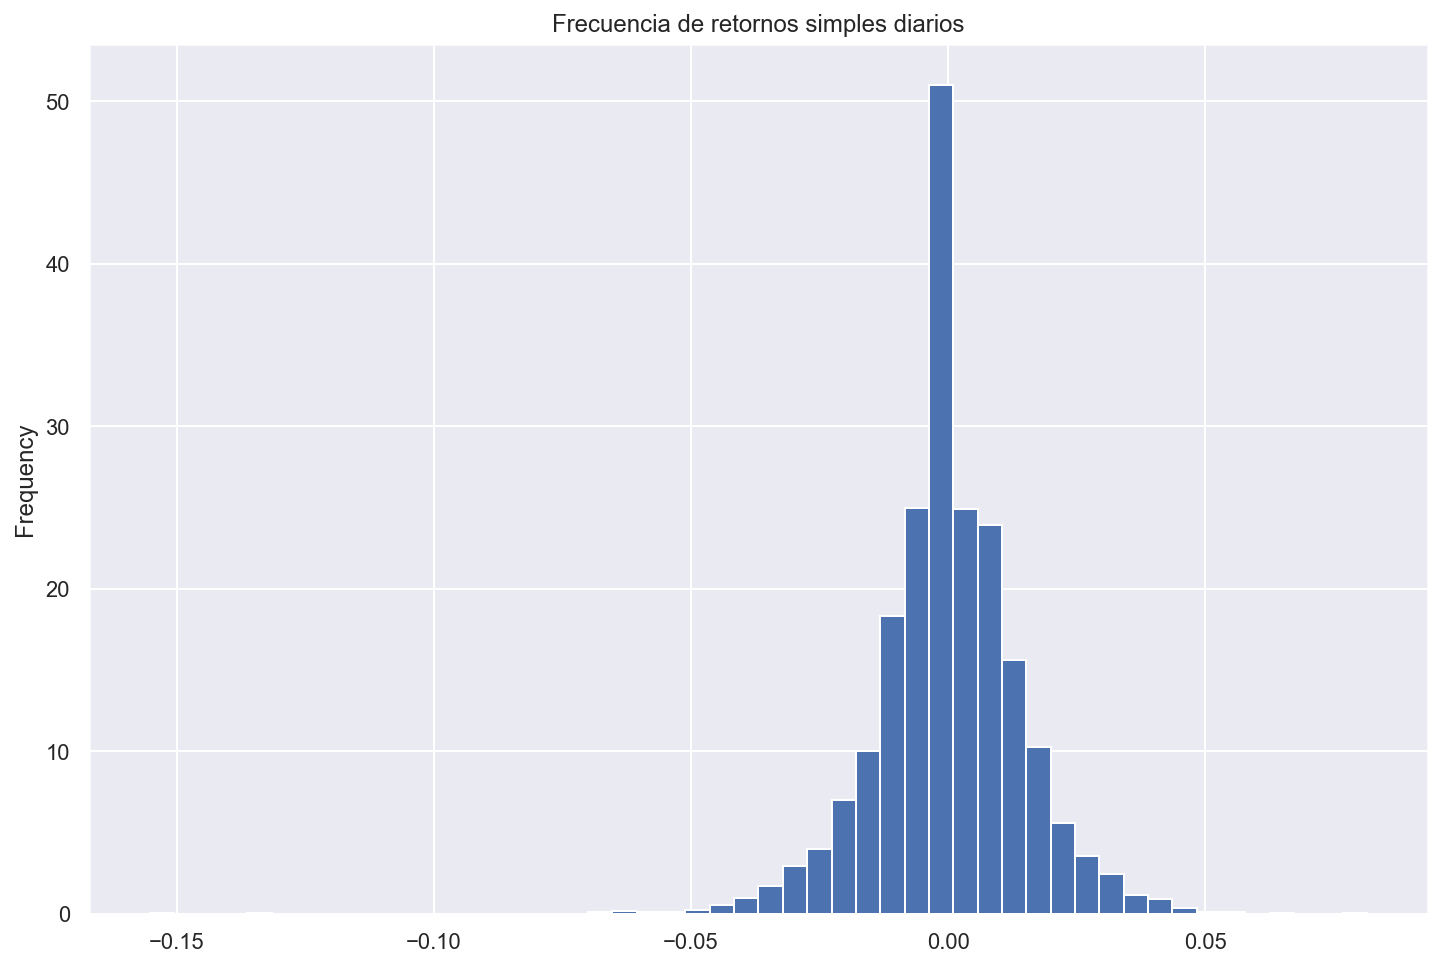

In [9]:
df['retorno'].plot(kind='hist', bins=50, title='Frecuencia de retornos simples diarios', density=True);

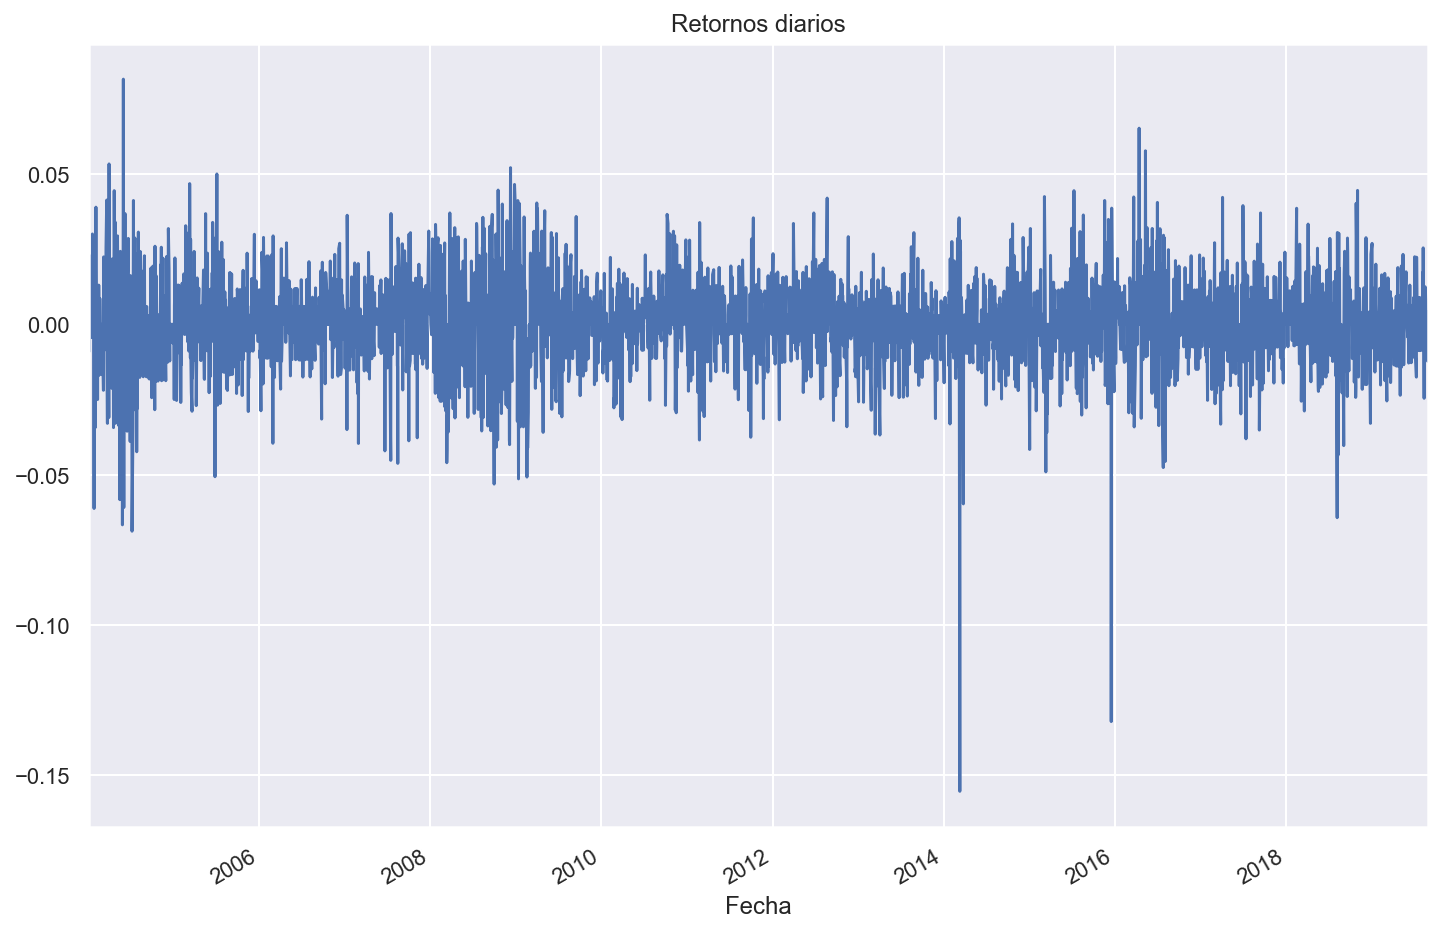

In [19]:
df['retorno'].dropna().plot(title='Retornos diarios');

Repetimos los plots de autocorrelación para la serie de retornos diarios.

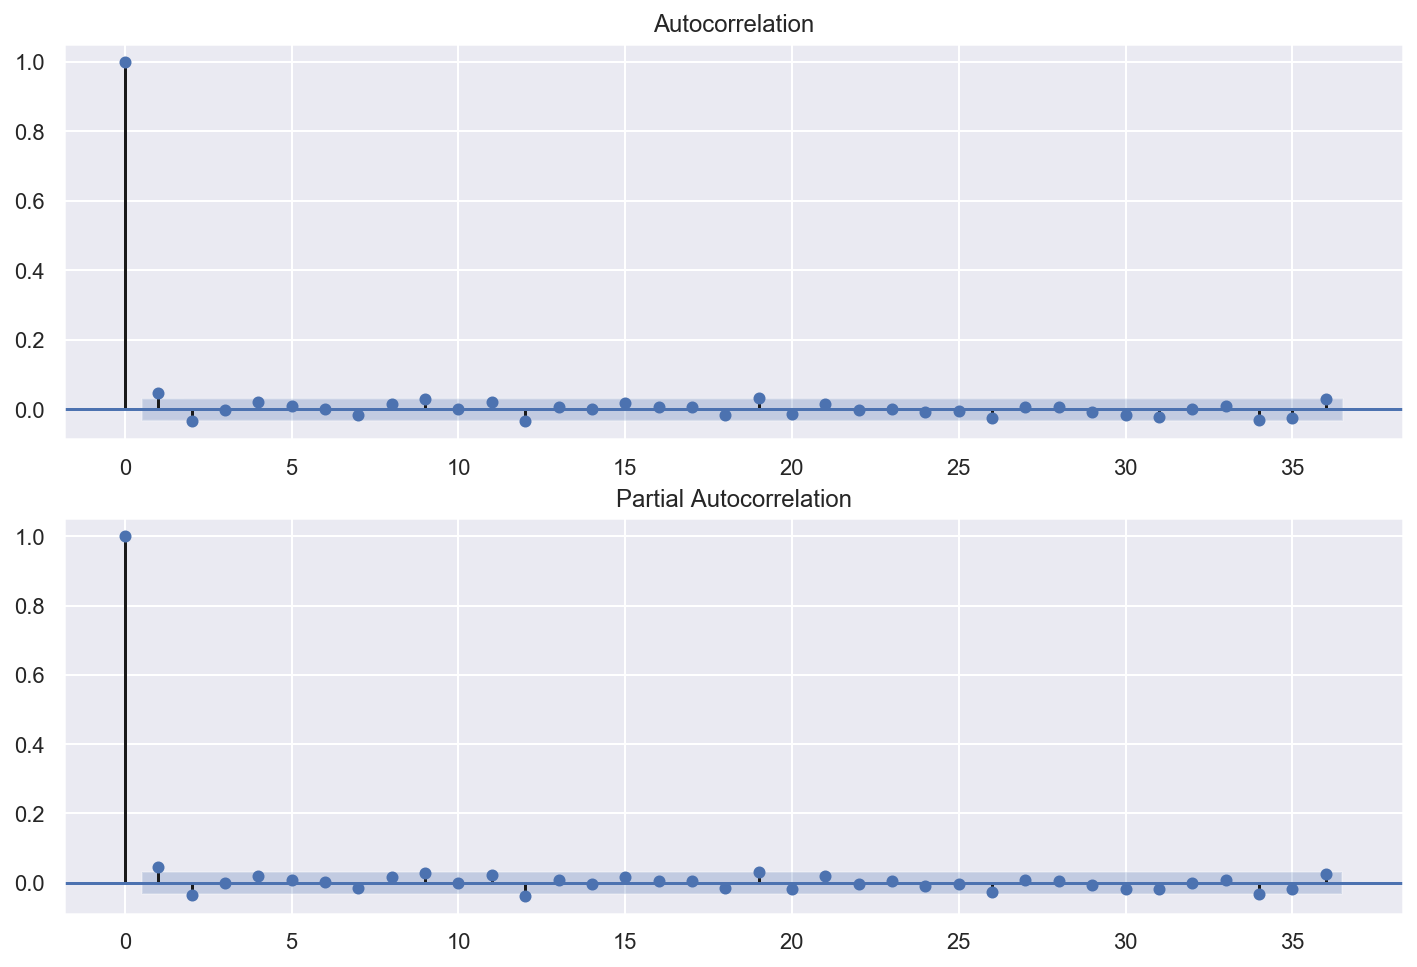

In [12]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df['retorno'].dropna(), ax=ax1)
sm.graphics.tsa.plot_pacf(df['retorno'].dropna(), ax=ax2);

Se ve claramente que al tomar retornos, la autocorrelación baja muy rápido al aumentar el lag, lo que nos dice que estamos en presencia de un proceso más estacionario. 

Nuestra herramienta principal para la predicción de los retornos será una combinación de los métodos ARIMA y GARCH. A continuación damos una breve explicación de ellos. 

[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) (*Autoregressive integrated moving average*) es un modelo aplicado a series de tiempo que considera al valor actual de la serie como una regresión sobre valores previos y al error de regresión como una combinación lineal de errores previos. Más precisamente, si la serie la notamos $\{Y_t\}_{t \in \mathbb{N}}$, el valor a tiempo $t$ se modela por $Y_t = \phi_0 + \sum_{i=1}^{p}{\phi_i Y_{t-i}} + \sum_{i=1}^{q}{\theta_i \varepsilon_{t-i}} + \varepsilon_t$, donde los $\varepsilon_i$ con $i\neq t$ son errores de regresión, $\varepsilon_t$ es [ruido blanco](https://es.wikipedia.org/wiki/Ruido_blanco) y los coeficientes $\phi_i$ y $\theta_i$ se ajustan típicamente a través de métodos estadísticos. La cantidad de pasos en el pasado que se consideran forma un par de hiperparámetros del modelo (los números $p$ y $q$), con un tercero (generalmente notado $d$) que determina cuántas veces diferenciar la serie antes de aplicarle lo anterior. Todo esto da un método $ARIMA(p,d,q)$. En nuestro caso tomamos $d=0$ porque aplicamos el método a los retornos, que ya son lo suficientemente estacionarios. Si lo quisiéramos aplicar al precio de cierre tomaríamos $d=1$ para diferenciarlo, obteniendo una serie muy similar a los retornos pero a otra escala (porque en cada paso no estaríamos diviendo por el precio del día anterior).

[GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) (*Generalized autoregressive conditional heteroskedasticity*) es otro modelo aplicado a series de tiempo para describir la varianza del error entre el valor observado y el que se había previsto (en nuestro caso, el término $\varepsilon_t$ que se consideraba ruido blanco). Típicamente esta varianza se escribe como combinación lineal de sus valores previos.

Juntando estas dos cosas, nuestro modelo se reduce a descomponer la serie de tiempo $Y_t$ como:

$$\begin{equation} 
Y_t = \mu_t + u_t 
\end{equation}$$

con $\mu_t$ la expresión dada por ARIMA (menos el término $\varepsilon_t$) y $u_t = \sigma_t \varepsilon_t$ el ruido, cuya varianza $\sigma^2_t$ se modela vía GARCH, escribiéndola como

$$\begin{equation}
\sigma^2_t = \alpha_0 + \sum_{i=1}^{s}{\alpha_i u_{t-i}^2} + \sum_{i=1}^{r}{\beta_i \sigma_{t-i}^2 }
\end{equation}$$

nuevamente para coeficientes $\alpha_i$, $\beta_i$ que deben ajustarse apropiadamente e hiperparámetros $r$ y $s$.

En realidad, nuestro modelo va a usar SARIMA (*Seasonal* ARIMA), una variante que permite controlar por componentes estacionales, pero las ideas son las mismas. En este caso consideramos una estacionalidad de seis meses correspondiente al ciclo de la soja. Para ver esto mejor, graficamos la descomposición estacional de nuestra serie de retornos por períodos de seis meses (aproximadamente 182 días).

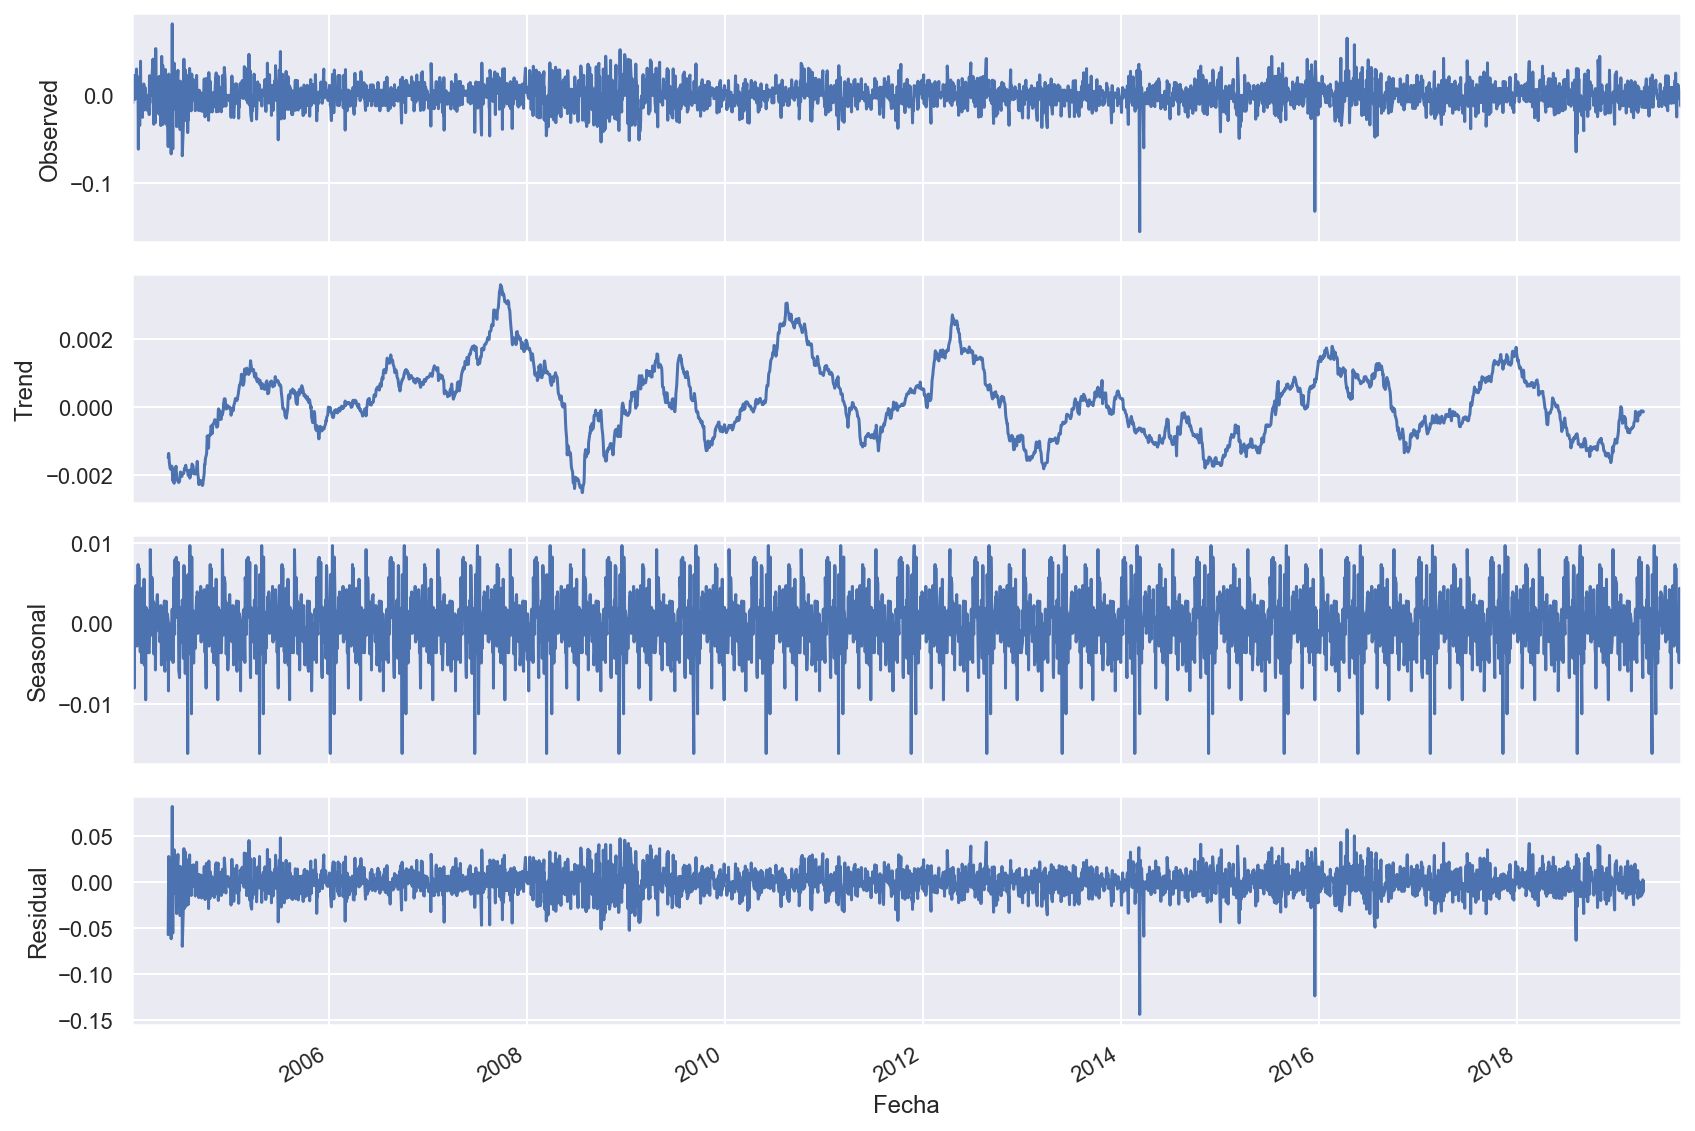

In [13]:
decomposicion = sm.tsa.seasonal_decompose(df['retorno'].dropna(), freq=182)
decomposicion.plot();

En el gráfico vemos un *trend* muy pequeño alrededor del cero (que nos sugiere que el retorno promedio es siempre cercano a cero) y una estacionalidad leve, que no llega a tener un impacto muy grande en el valor total de la serie pero igual puede ser tenida en cuenta.

### Facebook Prophet

Entre los alternativas que probamos, se encuentra la libreria [Prophet](https://facebook.github.io/prophet/) de Facebook, que implementa un modelo de decomposición aditiva con tres componentes: trend ($g(t)$), estacionalidad ($s(t)$) y feriados (_holidays_, $h(t)$).

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

Siendo $\epsilon_t$ un término de error que no ajusta el modelo. Este modelo es en esencia a un [modelo aditivo generalizado](https://es.wikipedia.org/wiki/Modelo_lineal_generalizado#Modelos_de_aditivos_generalizados) que utiliza el tiempo como regresor.  
Para más información, se puede consultar el [paper original](https://peerj.com/preprints/3190/).

In [29]:
from fbprophet import Prophet

In [46]:
data = pd.DataFrame({'ds': df.index, 'y': df['Cierre']})

model = Prophet(weekly_seasonality=False)
model.add_seasonality(name='bianual', period=182, fourier_order=5)
model.fit(data);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


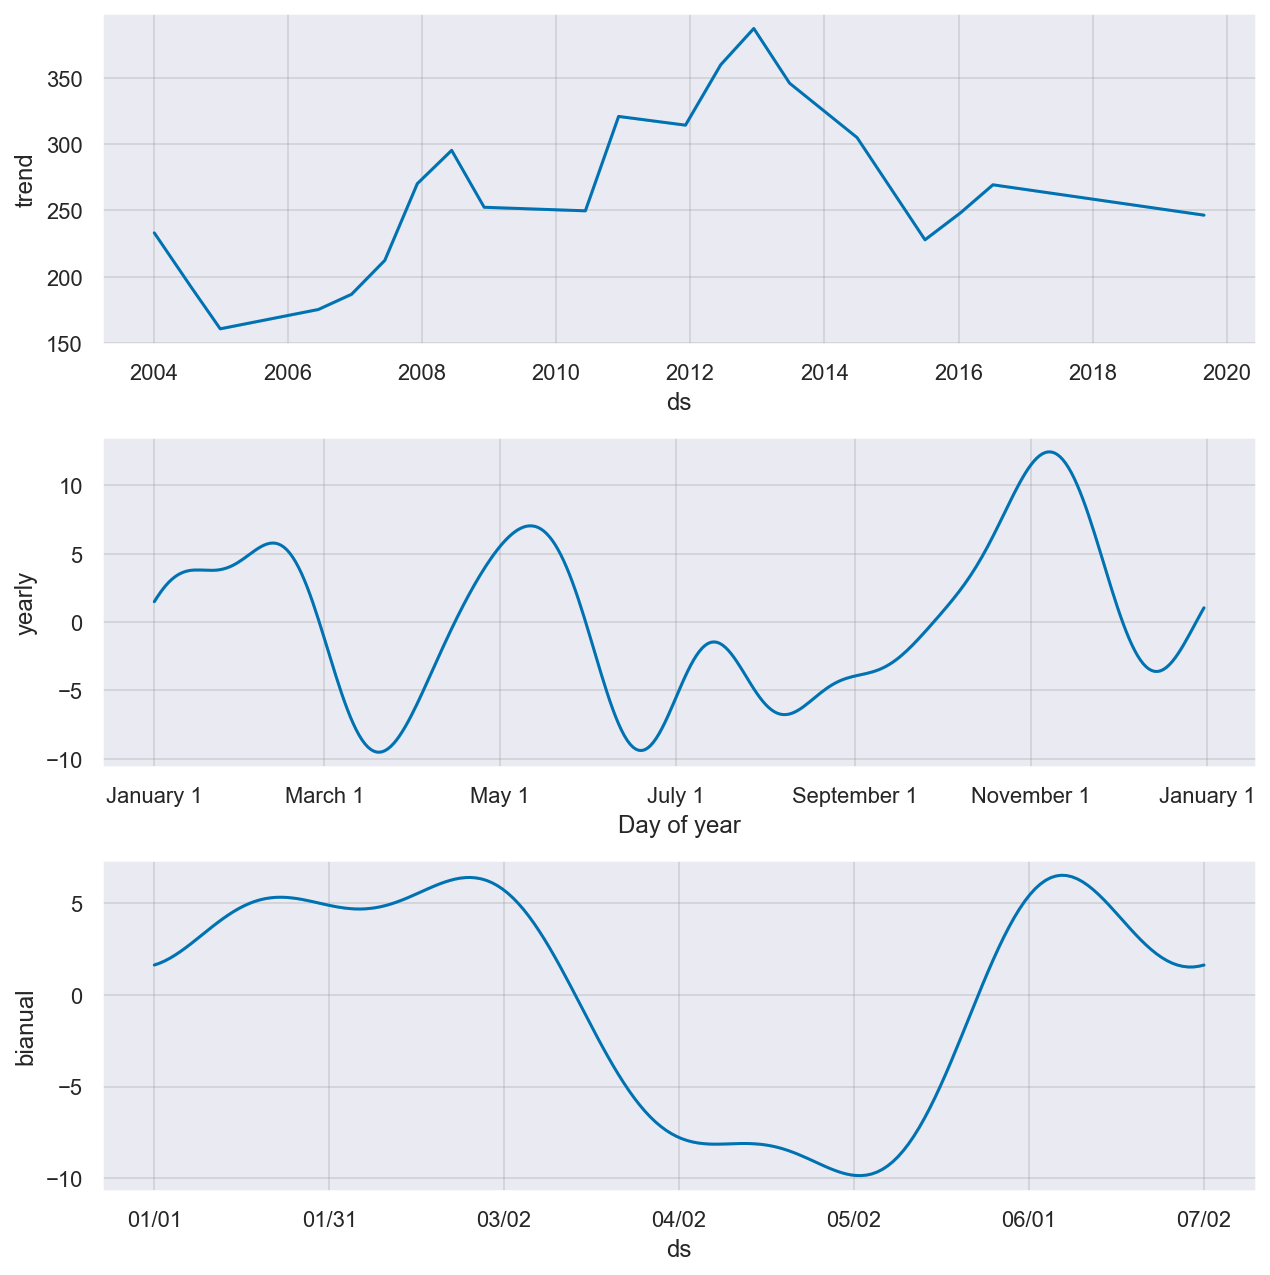

In [47]:
forecast = model.predict(data)
model.plot_components(forecast);

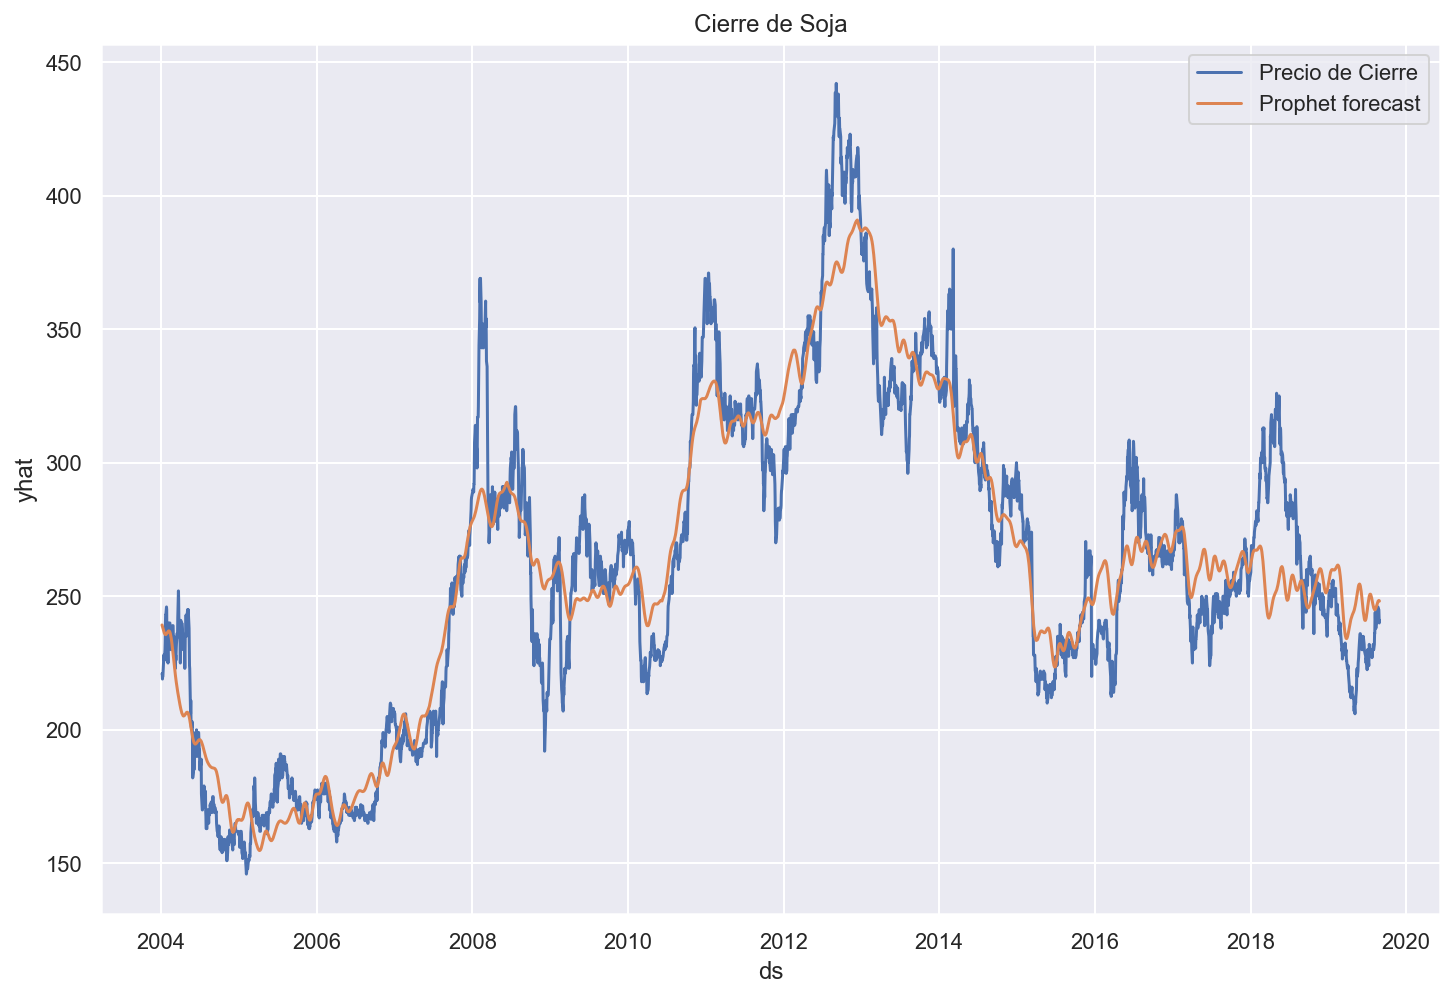

In [69]:
sns.lineplot(x=df.index, y=df['Cierre'], label='Precio de Cierre')
ax = sns.lineplot(y=forecast['yhat'], x=forecast['ds'], label='Prophet forecast')
ax.set_title('Cierre de Soja');

In [68]:
test_periods = pd.DataFrame({'ds': test_df.index})
prophet_predictions = model.predict(test_periods)
prophet_predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bianual,bianual_lower,bianual_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-30,246.471108,221.648848,272.730447,246.471108,246.471108,1.539022,1.539022,1.539022,5.622200,5.622200,5.622200,-4.083178,-4.083178,-4.083178,0.0,0.0,0.0,248.010129
1,2019-09-02,246.411094,220.334870,271.700729,246.411094,246.411094,0.745636,0.745636,0.745636,4.665880,4.665880,4.665880,-3.920243,-3.920243,-3.920243,0.0,0.0,0.0,247.156731
2,2019-09-03,246.391090,220.545584,272.703608,246.391090,246.391090,0.391044,0.391044,0.391044,4.265284,4.265284,4.265284,-3.874240,-3.874240,-3.874240,0.0,0.0,0.0,246.782134
3,2019-09-04,246.371086,222.024699,271.343202,246.371086,246.371086,-0.001995,-0.001995,-0.001995,3.826969,3.826969,3.826969,-3.828964,-3.828964,-3.828964,0.0,0.0,0.0,246.369091
4,2019-09-05,246.351081,219.981046,268.819686,246.351081,246.351081,-0.428649,-0.428649,-0.428649,3.353664,3.353664,3.353664,-3.782313,-3.782313,-3.782313,0.0,0.0,0.0,245.922432
5,2019-09-06,246.331077,219.795942,269.175874,246.331077,246.331077,-0.883648,-0.883648,-0.883648,2.848589,2.848589,2.848589,-3.732237,-3.732237,-3.732237,0.0,0.0,0.0,245.447429
6,2019-09-09,246.271064,218.571572,268.711942,246.271064,246.271064,-2.361516,-2.361516,-2.361516,1.181329,1.181329,1.181329,-3.542844,-3.542844,-3.542844,0.0,0.0,0.0,243.909548
7,2019-09-10,246.251059,217.681334,269.847683,246.251059,246.251059,-2.871921,-2.871921,-2.871921,0.589470,0.589470,0.589470,-3.461391,-3.461391,-3.461391,0.0,0.0,0.0,243.379139
8,2019-09-11,246.231055,217.043507,267.861489,246.231055,246.231055,-3.381256,-3.381256,-3.381256,-0.012526,-0.012526,-0.012526,-3.368731,-3.368731,-3.368731,0.0,0.0,0.0,242.849798
9,2019-09-12,246.211050,215.696274,267.735834,246.211050,246.211050,-3.883723,-3.883723,-3.883723,-0.619685,-0.619685,-0.619685,-3.264038,-3.264038,-3.264038,0.0,0.0,0.0,242.327327


In [78]:
prophet_predictions.set_index('ds', inplace=True)
prophet_predictions['retorno'] = prophet_predictions['yhat'].pct_change()

last = df.iloc[-1]['Cierre']
ret = (prophet_predictions['yhat'][0] - last)/ last
prophet_predictions['retorno'][0] = ret
prophet_predictions['retorno']

ds
2019-08-30    0.029088
2019-09-02   -0.003441
2019-09-03   -0.001516
2019-09-04   -0.001674
2019-09-05   -0.001813
2019-09-06   -0.001932
2019-09-09   -0.006266
2019-09-10   -0.002175
2019-09-11   -0.002175
2019-09-12   -0.002151
2019-09-13   -0.002105
2019-09-16   -0.005810
2019-09-17   -0.001714
Name: retorno, dtype: float64

In [84]:
prophet_mae = (prophet_predictions['retorno'] - test_df['retorno']).abs().sum() / len(test_df)
print('MAE of Prophet forecast:', prophet_mae)

MAE of Prophet forecast:  0.010401782881080004


In [124]:
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 182)
mod_sarimax = sm.tsa.statespace.SARIMAX(df['Cierre'], order=order, seasonal_order=seasonal_order)

In [ ]:
mod_fit = mod_sarimax.fit()

In [79]:
predicted = mod_fit.predict(start='2019-01-02', end='2019-08-29')

In [15]:
mod_garch = pf.GARCH(df, target='retorno', p=0, q=0)

In [16]:
garch_fit = mod_garch.fit('MLE')

In [17]:
garch_fit.summary()

GARCH(0,0)                                                                                                
======================================================= ==================================================
Dependent Variable: retorno                             Method: MLE                                       
Start Date: 2004-01-05 00:00:00                         Log Likelihood: nan                               
End Date: 2019-08-29 00:00:00                           AIC: nan                                          
Number of observations: 3854                            BIC: nan                                          
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0009                                                           
Returns Constant                     

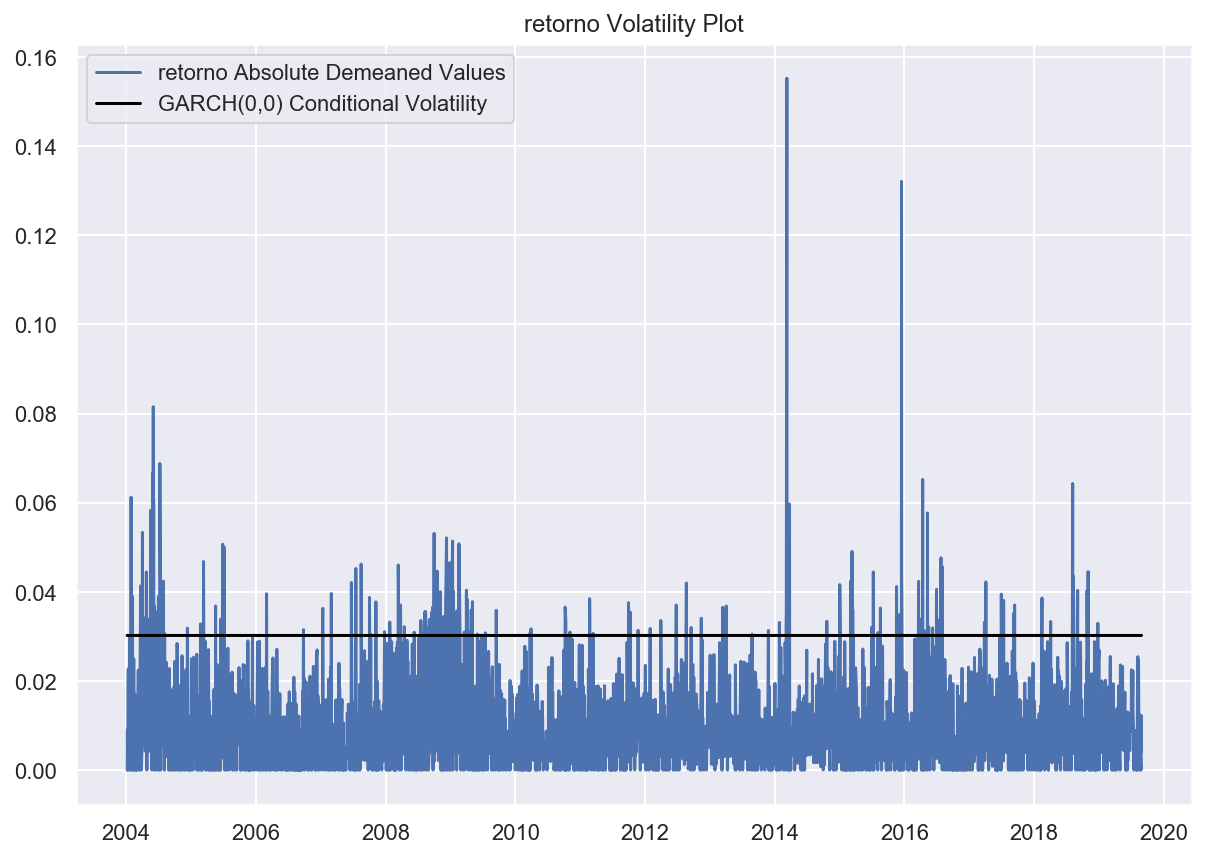

In [18]:
mod_garch.plot_fit()

In [119]:
arma_garch = mod_fit.predict(start=len(df['retorno']), end=len(df['retorno']) + 9) + mod_garch.predict(10)['Series']

In [131]:
last = df.iloc[-1]['Cierre']

In [136]:
shifted = (arma_garch + 1)

In [142]:
dff = pd.DataFrame(shifted)

In [146]:
dff.columns = ['ret']

In [149]:
dff

,ret
3854,0.999991
3855,1.000174
3856,1.000411
3857,1.000133
3858,1.000254
3859,0.999810
3860,1.000175
3861,0.999964
3862,1.000710
3863,0.999823


In [150]:
dff['predicted'] = dff['ret'].cumprod()

In [154]:
prices = dff['predicted'] * last

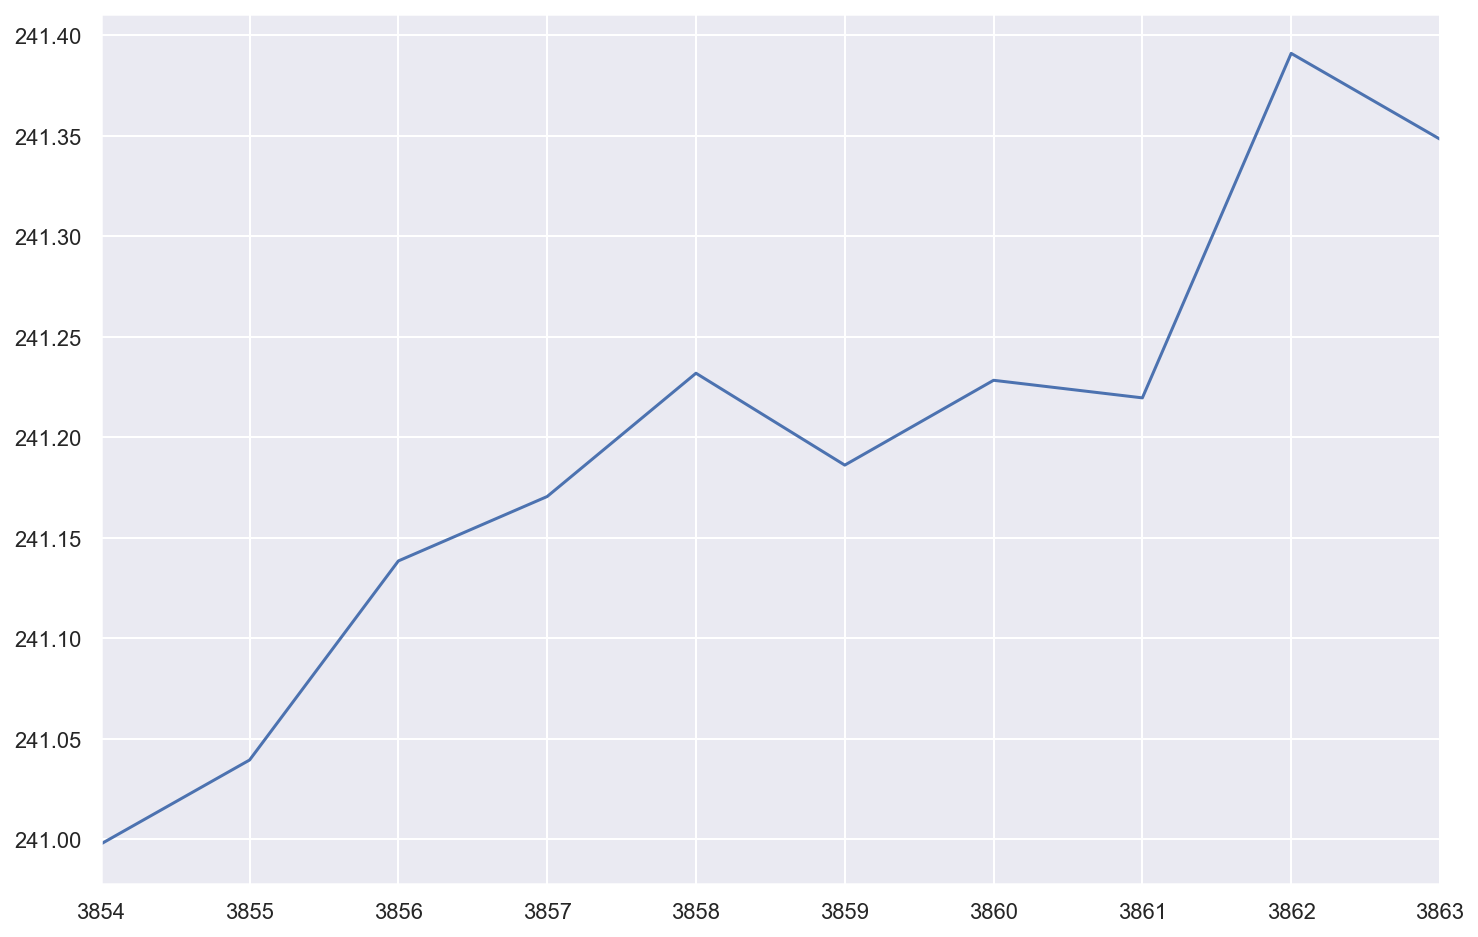

In [155]:
prices.plot()

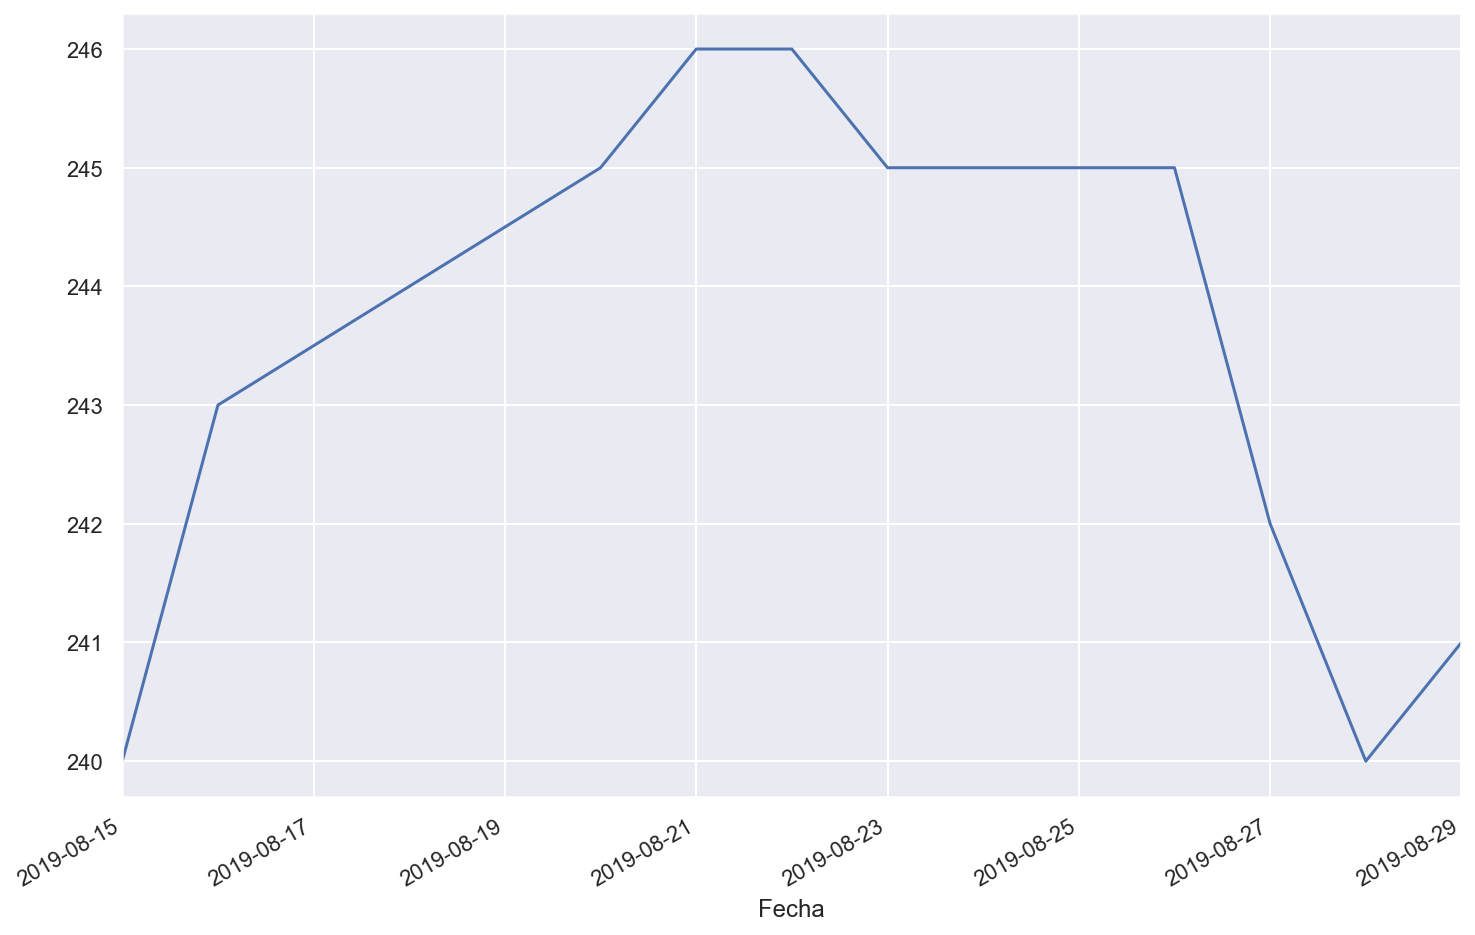

In [135]:
df['Cierre'].tail(10).plot()

In [7]:
grid_params = {
    'order': [(1, 0, 1), (1, 1, 1), (2, 0, 1)],
    'seasonal_order': [(0, 0, 0), [1, 0, 1]],
    'season_periods': [182],
    'garch_params': [(1, 1), (0, 0), (2, 1)]
}

In [60]:
test_df = pd.read_csv(os.path.join(data_dir, 'Futuros.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

In [61]:
test_df['retorno'] = test_df['Cierre'].pct_change()
test_df['log_retorno'] = np.log(test_df['Cierre'] / test_df['Cierre'].shift(1))

In [81]:
last = df.iloc[-1]['Cierre']
ret = (test_df['Cierre'][0] - last)/ last
test_df['retorno'][0] = ret
test_df['retorno']

Fecha
2019-08-30   -0.016598
2019-09-02    0.000000
2019-09-03   -0.008439
2019-09-04    0.029787
2019-09-05    0.000000
2019-09-06   -0.008264
2019-09-09   -0.004167
2019-09-10    0.008368
2019-09-11   -0.004149
2019-09-12    0.000000
2019-09-13    0.008333
2019-09-16    0.000000
2019-09-17   -0.008264
Name: retorno, dtype: float64

In [ ]:
from grid_search import grid_search

results = grid_search(df['retorno'], test_df['retorno'], grid_params)

In [91]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(df['Cierre'],
                             start_p=0,
                             start_q=0,
                             max_p=3,
                             max_q=3,
                             start_P=0,
                             start_Q=0,
                             seasonal=True,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=21219.487, BIC=21232.001, Fit time=0.124 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=21213.327, BIC=21232.097, Fit time=0.242 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=21213.147, BIC=21231.917, Fit time=0.240 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=21214.590, BIC=21239.616, Fit time=0.602 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=21214.749, BIC=21239.775, Fit time=0.409 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=21216.570, BIC=21247.853, Fit time=1.102 seconds
Total fit time: 2.725 seconds


In [92]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3854
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -10603.573
Date:                Thu, 19 Sep 2019   AIC                          21213.147
Time:                        13:44:25   BIC                          21231.917
Sample:                             0   HQIC                         21219.813
                               - 3854                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.067      0.077      0.938      -0.127       0.137
ma.L1          0.0470      0.011      4.375      0.000       0.026       0.068
sigma2        14.3849      0.116    123.660      0.000      14.157      14.613
===================================================================================
Ljung-Box (Q):                       39.66   Jarque-Bera (JB):             58152.52
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -1.33
Prob(H) (two-sided):                  0.35   Kurtosis:                        21.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
retorno_fit = pm.auto_arima(df['retorno'].dropna(),
                             start_p=0,
                             start_q=0,
                             max_p=3,
                             max_q=3,
                             start_P=0,
                             start_Q=0,
                             seasonal=True,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21808.796, BIC=-21796.283, Fit time=0.487 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21814.693, BIC=-21795.923, Fit time=0.387 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21815.270, BIC=-21796.500, Fit time=0.578 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21815.616, BIC=-21790.590, Fit time=0.835 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-21815.380, BIC=-21784.097, Fit time=1.113 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-21814.499, BIC=-21776.959, Fit time=1.907 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21815.649, BIC=-21784.366, Fit time=2.007 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-21817.649, BIC=-21792.623, Fit time=0.337 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-21813.652, BIC=-21776.112, Fit time=2.556 seconds
F

In [106]:
test_df['arima_predict'] = stepwise_fit.predict(len(test_df))

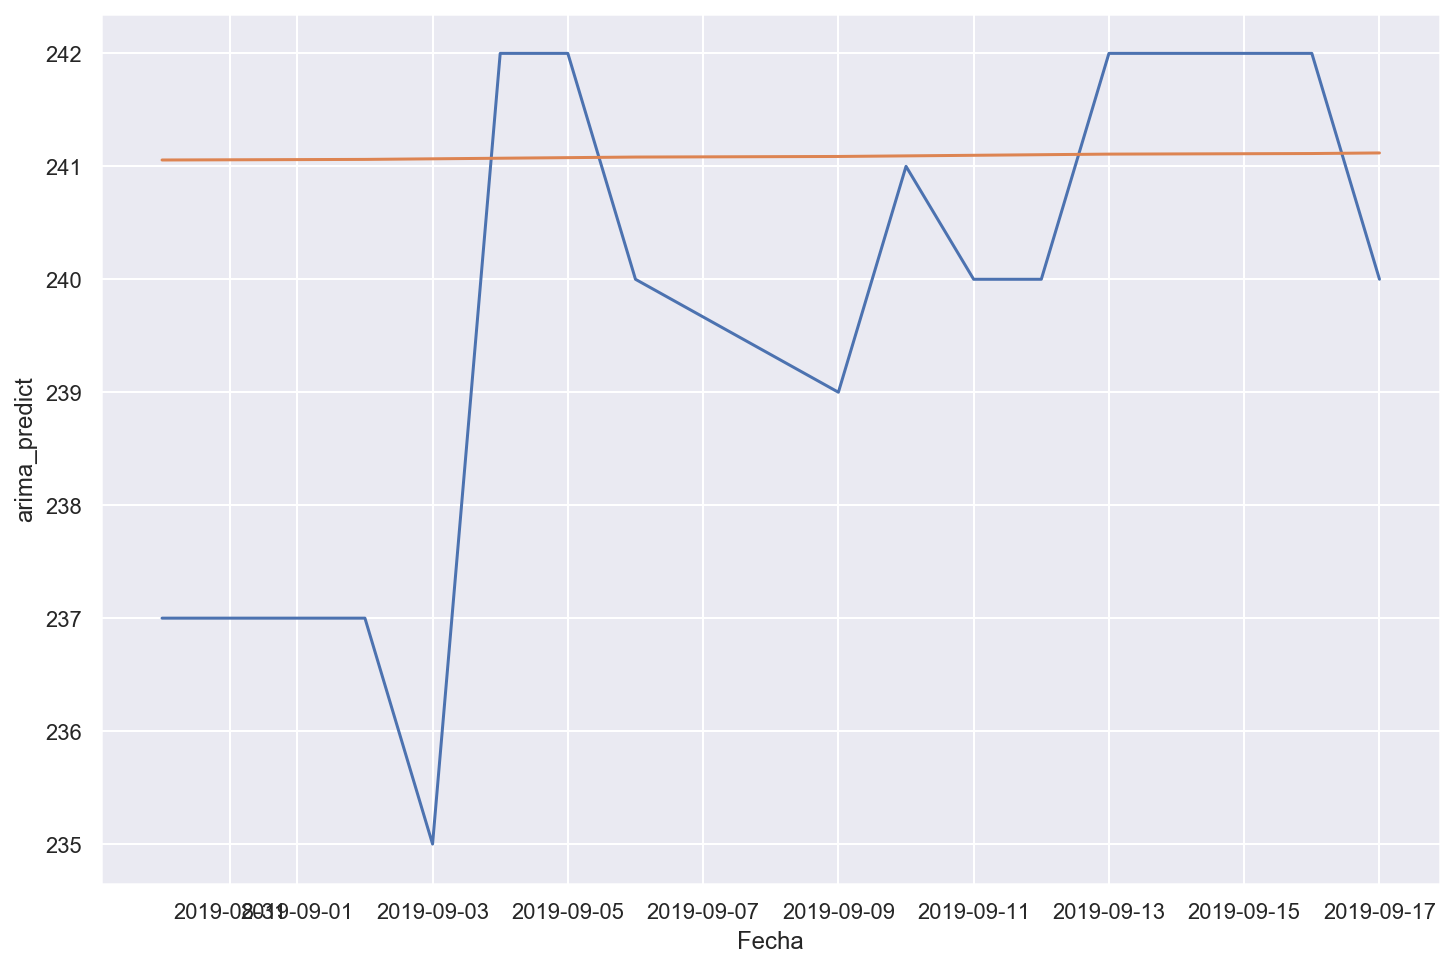

In [107]:
ax = sns.lineplot(x=test_df.index, y=test_df['Cierre'])
sns.lineplot(x=test_df.index, y=test_df['arima_predict'], ax=ax);

In [95]:
retorno_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3853
Model:               SARIMAX(2, 0, 0)   Log Likelihood               10912.825
Date:                Thu, 19 Sep 2019   AIC                         -21817.649
Time:                        13:45:51   BIC                         -21792.623
Sample:                             0   HQIC                        -21808.761
                               - 3853                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.525      0.600      -0.000       0.001
ar.L1          0.0469      0.012      3.899      0.000       0.023       0.070
ar.L2         -0.0359      0.012     -2.911      0.004      -0.060      -0.012
sigma2         0.0002   2.36e-06     85.988      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.04   Jarque-Bera (JB):              8239.05
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
retorno_fit.predict(10)

array([6.15839485e-04, 3.55408691e-06, 1.02197431e-04, 1.28780589e-04,
       1.26489036e-04, 1.25428237e-04, 1.25460692e-04, 1.25500258e-04,
       1.25500949e-04, 1.25499562e-04])

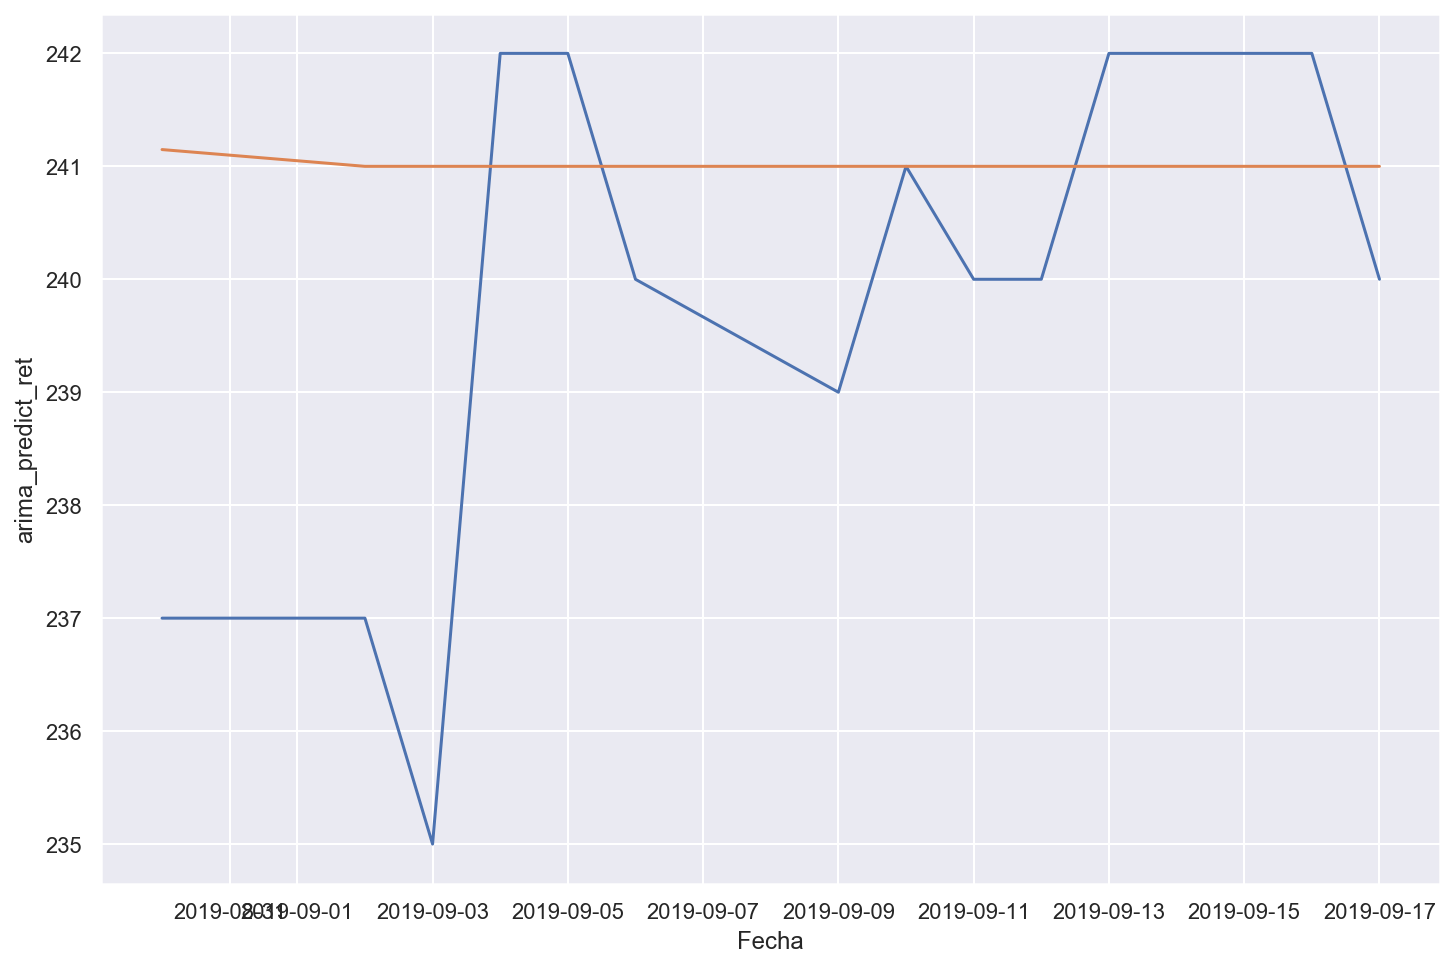

In [109]:
test_df['arima_predict_ret'] = retorno_fit.predict(len(test_df))
ax = sns.lineplot(x=test_df.index, y=test_df['Cierre'])
sns.lineplot(x=test_df.index, y=(test_df['arima_predict_ret'].cumprod() + 1) * last, ax=ax);

In [ ]:
mu, Y = arima._model(arima.latent_variables.get_z_values())
values=arima.link(mu)